In [35]:
import multiprocessing
from pathlib import Path

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import DatasetDict
from IPython.display import Audio as display_audio

In [2]:
sanity_check = False

n_cpu = multiprocessing.cpu_count() - 5; n_cpu
data_path = Path("/data/volume")
audio_path = data_path / "audio"
audio_path.mkdir(parents=True, exist_ok=True)

## Load model

In [3]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Load Dataset

In [9]:
dataset_path = data_path / "tts-training-20k-processed-phono-"
dataset = DatasetDict.load_from_disk(dataset_path)
dataset

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 4000
    })
})

In [10]:
if sanity_check:
    dataset["train"] = dataset["train"].select(range(1000))
    dataset["test"] = dataset["test"].select(range(200))

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path'],
        num_rows: 4000
    })
})

In [12]:
dataset["train"][0]

{'uni': 'དེའི་ཚེ་འཇིག་རྟེན་སྐྱེ་བ་ན་གང་ཟག་ཉག་གཅིག་སྐྱེའོ་ཞེས་བྱ་བའི་ལུང་ལས་ནི། ཕ་རོལ་པོས་བདག་མང་པོར་འདོད་པ་ཡང་མིན་ནོ།',
 'sentence': 'téɪ  tsé  jik  tèn  kyé  pa  na  kang  sak  nyak  chik  kyéo  shè  cha  paɪ  lung  lè  ni  pa  röl  pö  dak  mang  por  dö  pa  yang  min  no',
 'label': 'STT_AB',
 'speaker_id': '43eb8725-a871-476c-a0c3-6ff211c79aad',
 'duration': 8.276,
 'tokens_len': 130,
 'path': {'path': 'STT_AB00636_0179_1285247_to_1293523.wav',
  'array': array([-0.00021362, -0.00032043, -0.00027466, ...,  0.01182556,
          0.01246643,  0.01217651]),
  'sampling_rate': 16000}}

In [13]:
def resolve_audio_path(item):
    item["path"] = str(audio_path / item["path"]["path"])
    return item

In [14]:
dataset = dataset.map(resolve_audio_path, num_proc=n_cpu)

Map (num_proc=59):   0%|          | 0/16000 [00:00<?, ? examples/s]

Map (num_proc=59):   0%|          | 0/4000 [00:00<?, ? examples/s]

In [15]:
dataset["train"][0]

{'uni': 'དེའི་ཚེ་འཇིག་རྟེན་སྐྱེ་བ་ན་གང་ཟག་ཉག་གཅིག་སྐྱེའོ་ཞེས་བྱ་བའི་ལུང་ལས་ནི། ཕ་རོལ་པོས་བདག་མང་པོར་འདོད་པ་ཡང་མིན་ནོ།',
 'sentence': 'téɪ  tsé  jik  tèn  kyé  pa  na  kang  sak  nyak  chik  kyéo  shè  cha  paɪ  lung  lè  ni  pa  röl  pö  dak  mang  por  dö  pa  yang  min  no',
 'label': 'STT_AB',
 'speaker_id': '43eb8725-a871-476c-a0c3-6ff211c79aad',
 'duration': 8.276,
 'tokens_len': 130,
 'path': {'path': '/data/volume/audio/STT_AB00636_0179_1285247_to_1293523.wav',
  'array': array([-0.00021362, -0.00032043, -0.00027466, ...,  0.01182556,
          0.01246643,  0.01217651]),
  'sampling_rate': 16000}}

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [16]:
tokenizer = processor.tokenizer
a = tokenizer.get_vocab().items()

In [17]:
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset['train'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['train'].column_names,
)
vocabs = dataset['test'].map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset['test'].column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [18]:
len(dataset_vocab), len(tokenizer_vocab)

(31, 81)

In [19]:
dataset_vocab-tokenizer_vocab


{' ', 'è', 'ö', 'ü', 'ɪ', 'ʂ', 'ḍ', 'ṅ', 'ṭ'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [16]:
replacements = [
    ('è', 'e'),  # Similar to "e" in "bed"
    ('ö', 'oe'), # Similar to "o" in "bird" or "u" in "burn" (British accent)
    ('ü', 'u'),  # Similar to "u" in "lune" or "y" in "myth" with rounded lips
    ('ɪ', 'i'),  # Similar to "i" in "bit"
    ('ʂ', 'sh'), # Similar to "sh" in "sheep" with retroflexion
    ('ḍ', 'd'),  # Retroflex "d" similar to hard "d"
    ('ṅ', 'ng'), # Similar to "ng" in "sing"
    ('ṭ', 't'),  # Retroflex "t" similar to hard "t"
]
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["sentence"] = inputs["sentence"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text, num_proc=n_cpu)

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [20]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device ="cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/tmp/ipykernel_42435/2420507585.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [21]:
def prepare_dataset(batch):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio_batch = batch["path"]
    sentence_batch = batch["sentence"]
    audio_array_batch = [audio["array"] for audio in audio_batch]
    sampling_rate = audio_batch[0]["sampling_rate"]

    example = processor(
        text=sentence_batch,
        audio_target=audio_array_batch,
        sampling_rate=sampling_rate,
        return_attention_mask=False,
    )

    example["sentence"] = sentence_batch
    example["labels"] = [label for label in example["labels"]]
    example["path"] = audio_batch
    example["speaker"] = batch['speaker_id']
    example["uni"] = batch["uni"]
    example["speaker_embeddings"] = [create_speaker_embedding(array) for array in audio_array_batch]

    return example

Let's verify the processing is correct by looking at a single example:

In [22]:
processed_example = prepare_dataset(dataset['train'].select(range(5)))
processed_example["speaker_embeddings"][0].shape

(512,)

In [23]:
processed_example["labels"][0].shape

(518, 80)

In [24]:
processed_example["uni"]

['དེའི་ཚེ་འཇིག་རྟེན་སྐྱེ་བ་ན་གང་ཟག་ཉག་གཅིག་སྐྱེའོ་ཞེས་བྱ་བའི་ལུང་ལས་ནི། ཕ་རོལ་པོས་བདག་མང་པོར་འདོད་པ་ཡང་མིན་ནོ།',
 'རྒྱུ་མཚན་བསམ་པའི་སྟོབས་ལ་བརྟེན་ནས་ཉོན་མོངས་དེ་ལས་གྲོལ་དགོས་པ་རེད།',
 'སྲོག་རྩོལ་ངག་དབེན་དུ་འདུ།',
 'ཐེར་འདོན་བྱེད། ཁོང་ཚོ་ངོ་གནོངས་ནས་གཞུང་གིས་ཀུན་སློང་ངན་པ་བཅངས་པ་མ་རེད་ཅེས་ཨུ་ཚུགས་ཀྱིས་བརྗོད།',
 'ངག་དབེན་གྱི་སྐབས་སུ་ངག་གི་རྩ་བ་རླུང་ལ་དབང་ཐོབ་པ་གཉིས་ཆོས་མཚུངས་པའི་ཕྱིར།']

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [25]:
list(processed_example.keys())

['input_ids',
 'labels',
 'sentence',
 'path',
 'speaker',
 'uni',
 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [26]:
[tokenizer.decode(input_ids) for input_ids in processed_example["input_ids"]]

['té<unk> tsé jik t<unk> n kyé pa na kang sak nyak chik kyéo sh<unk> cha pa<unk> lung l<unk> ni pa r<unk> l p<unk> dak mang por d<unk> pa yang min no</s>',
 'gyu ts<unk> n sam pa<unk> top la t<unk> n n<unk> ny<unk> n mong té l<unk> <unk> l g<unk> pa r<unk></s>',
 'sok ts<unk> l <unk> ak <unk> n tu du</s>',
 't<unk> r d<unk> n ch<unk> kong tso <unk> o nong n<unk> shung ki k<unk> n long <unk> n pa chang pa ma r<unk> ch<unk> u tsuk kyi j<unk></s>',
 '<unk> ak <unk> n kyi kap su <unk> ak ki tsa pa lung la wang top pa nyi ch<unk> tsung pa<unk> chir</s>']

Speaker embeddings should be a 512-element vector:

In [27]:
processed_example["speaker_embeddings"][0].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

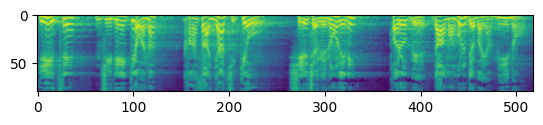

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"][0].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [29]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [30]:
i = 3
print(processed_example["uni"][i])
print(processed_example["sentence"][i])
spectrogram = torch.tensor(processed_example["labels"][i])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

ཐེར་འདོན་བྱེད། ཁོང་ཚོ་ངོ་གནོངས་ནས་གཞུང་གིས་ཀུན་སློང་ངན་པ་བཅངས་པ་མ་རེད་ཅེས་ཨུ་ཚུགས་ཀྱིས་བརྗོད།
tèr  dön  chè  kong  tso  ṅo  nong  nè  shung  ki  kün  long  ṅèn  pa  chang  pa  ma  rè  chè  u  tsuk  kyi  jö


model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

In [31]:
dataset["train"][0]["uni"]

'དེའི་ཚེ་འཇིག་རྟེན་སྐྱེ་བ་ན་གང་ཟག་ཉག་གཅིག་སྐྱེའོ་ཞེས་བྱ་བའི་ལུང་ལས་ནི། ཕ་རོལ་པོས་བདག་མང་པོར་འདོད་པ་ཡང་མིན་ནོ།'

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [32]:
dataset['train'].column_names

['uni', 'sentence', 'label', 'speaker_id', 'duration', 'tokens_len', 'path']

In [34]:
dataset = dataset.map(
    prepare_dataset,
    remove_columns=dataset['train'].column_names,
    batched=True,
    batch_size=128
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
dataset['train'].column_names

In [ ]:
import random
i = random.choice(range(len(dataset["train"])))
print(dataset["train"][i]["uni"])
print(dataset["train"][i]["sentence"])
spectrogram = torch.tensor(dataset["train"][i]["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)
display_audio(speech.cpu().numpy(), rate=16000)

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [40]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [58]:
models_path = data_path / "models" / "exp3-poc"
models_path.mkdir(exist_ok=True, parents=True)

model_name = "TTS_st5_phono_20k"
model_path = models_path / model_name

In [59]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=str(model_path),
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    num_train_epochs=30,
    learning_rate=1e-5,
    warmup_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    save_steps=2000,
    eval_steps=2000,
    logging_steps=100,
    save_total_limit=5,
    report_to=["wandb"],
    label_names=["labels"],
)

/home/jovyan/.conda/envs/jupyter-base/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [60]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)
torch.cuda.empty_cache()

/tmp/ipykernel_56069/54815936.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [61]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1, training_loss=12.11713981628418, metrics={'train_runtime': 33.4971, 'train_samples_per_second': 29.853, 'train_steps_per_second': 0.03, 'total_flos': 139219410078144.0, 'train_loss': 12.11713981628418, 'epoch': 1.0})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "VoxPopuli",  # a 'pretty' name for the training dataset
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "SpeechT5 TTS Dutch",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

You can now share this model with anyone using the link on the Hub.

In [49]:
model.push_to_hub(model_name)

pytorch_model.bin:   0%|          | 0.00/578M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spsitherMonlamAI/TTS_AB-all_run2/commit/ef311f60f14f98ce4fde289d924184107c21fc91', commit_message='Upload SpeechT5ForTextToSpeech', commit_description='', oid='ef311f60f14f98ce4fde289d924184107c21fc91', pr_url=None, pr_revision=None, pr_num=None)